In [33]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from river import anomaly, preprocessing, compose, ensemble, neighbors, datasets
from river.utils import numpy2dict
from math import ceil, floor
from matplotlib import pyplot as plt
from scipy import stats

In [147]:
'''
EXTERNAL KERNEL
'''
google_colab = False
kaggle = False

'''
CUDA
'''
cuda = False

'''
DATA REPRESENTATION

1 => SINGLE READ | 2 => ADD FEATURES | 3 => WINDOW TO FEATURES
'''
DATA_REPRESENTATION = 1

'''
DOWNSAMPLE FACTOR

1 => 10hz *original rate* | 2 => 5Hz | 5 => 2Hz | 10 => 1hz
'''
DOWNSAMPLE_FACTOR = 5

'''
WINDOWS LENGHT

* needs divisor by datapoints target
* considering downsample factor = 5

1 => WINDOW DISABLED | 2 => 1 second | 4 => 2 seconds | 10 => 5 seconds | 20 => 10 seconds | 200 => 100 seconds *full flight*
'''
WINDOW_LENGHT =  1

'''
LIMITADOR

Quantity of samples in the execution of the tests.
'''
LIMITADOR = None

'''
LOSS FACTOR [0,1]

Ignores outliers in calculating the stats of losses in regenerated data.
'''
LOSS_FACTOR = 1

'''
TRAIN_SIZE [0,1]

Percentage of samples to be trained
'''
TRAIN_SIZE = 0.8

'''
OUTPUT_FILE_NAME

File with output results
'''
OUTPUT_FILE_NAME = 'output_hst_river_dr_' + str(DATA_REPRESENTATION) + '-ts_' + str(TRAIN_SIZE) + '-lf_' + str.replace(str(LOSS_FACTOR), '.', '') + '-limit_' + str(LIMITADOR) + '-wl_' + str(WINDOW_LENGHT) + '.txt'

'''
PATH_OUTPUTS

'''
PATH_OUTPUTS = './outputs/'

'''
PATH_DATASET

'''
PATH_DATASET = '../../dataset/original/'

'''
FLUSH FILE

If output results file is ON
'''
FLUSH_FILE = False

In [140]:
if google_colab:
    from google.colab import drive

    drive.mount('/content/drive')
    path = '/content/drive/My Drive/ACADÊMICO/MESTRADO/DISSERTAÇÃO/CHAPTERS/5 EXPERIMENTO/dataset/data_representation_1'
    dict_ds_original = {
        'data_ds3_normal_t1_original' : pd.read_csv(path+'/F16_DS3_normal_t1.csv', header=None),
        'data_ds3_normal_t2_original' : pd.read_csv(path+'/F16_DS3_normal_t2.csv', header=None),
        'data_ds3_fault1_original' : pd.read_csv(path+'/F16_DS3_fault1_leakage.csv', header=None),
        'data_ds3_fault2_original' : pd.read_csv(path+'/F16_DS3_fault2_viscousfriction.csv', header=None),
        'data_ds3_fault3_original' : pd.read_csv(path+'/F16_DS3_fault3_compressibility.csv', header=None),
        'data_ds3_fault4_original' : pd.read_csv(path+'/F16_DS3_fault4_fixedposition.csv', header=None),
    }
elif kaggle:
    !conda install -y gdown
    !gdown --id 1G88okIVmdcgLFlmd7rDRhHvHv98yK3UB
    !gdown --id 1fX3utfHMjwKTt7IW4D01bnm-hv88yzrJ
    !gdown --id 1yUG3R5zK2AIxtS9Q4Fk-udkKBZeYShgb
    !gdown --id 1OBRDtuqNEZ-3Z-q0helWh2xGiAxeLACH
    !gdown --id 17oDi60sWYsWHHxzj2aA9m6ARm8zQ81m_
    !gdown --id 1jKEK4s5sYJh8PHtpHeV8ABOsHjuB26RA
else:
    dict_ds_original = {
        'data_ds3_normal_t1_original' : pd.read_csv(PATH_DATASET+'F16_DS3_normal_t1.csv', header=None),
        'data_ds3_normal_t2_original' : pd.read_csv(PATH_DATASET+'F16_DS3_normal_t2.csv', header=None),
        'data_ds3_fault1_original' : pd.read_csv(PATH_DATASET+'F16_DS3_fault1_leakage.csv', header=None),
        'data_ds3_fault2_original' : pd.read_csv(PATH_DATASET+'F16_DS3_fault2_viscousfriction.csv', header=None),
        'data_ds3_fault3_original' : pd.read_csv(PATH_DATASET+'F16_DS3_fault3_compressibility.csv', header=None),
        'data_ds3_fault4_original' : pd.read_csv(PATH_DATASET+'F16_DS3_fault4_fixedposition.csv', header=None),
    }

In [141]:
dict_ds = dict_ds_original.copy()

if dict_ds['data_ds3_normal_t1_original'].shape[0] % DOWNSAMPLE_FACTOR != 0 or dict_ds['data_ds3_fault1_original'].shape[0] % DOWNSAMPLE_FACTOR != 0:
    raise Exception('Needs to be ?shape? divisor')

for n, dataset_name in enumerate(dict_ds):
    dataset = dict_ds[dataset_name].to_numpy()

    downsampled = dataset[::DOWNSAMPLE_FACTOR]

    x, y = downsampled.shape

    # resample
    dict_ds[dataset_name] = pd.DataFrame(downsampled.reshape((int(x/WINDOW_LENGHT),y*WINDOW_LENGHT)))


In [142]:
# ADD COLUMNS WITH DIFF PREVIOUS VALUES

if (DATA_REPRESENTATION == 2):
    frame_size = int(1000/DOWNSAMPLE_FACTOR)

    for n, dataset_name in enumerate(dict_ds):
        dataset = dict_ds[dataset_name].to_numpy()

        dimension = dataset.shape[1]
        samples = dataset.shape[0]

        # GENERATE NEW DIMENSIONS
        dataset = np.concatenate((dataset, np.zeros((samples,dimension))), axis=1)

        for f in np.arange(0,int(samples/frame_size)):
            # OBTAIN THE FRAME FLIGHT
            frame = dataset[f*frame_size:(f+1)*frame_size, 0:dimension]

            # CALCULATE DIFFERENCE
            chunk = np.diff(frame, axis=0)

            # DONT CALCULATE THE DIFFERENCE FOR EACH FIRST TIMESTEP
            chunk = np.insert(chunk, 0, frame[0, 0:dimension], axis=0)

            # UPDATE DATASET WITH NEW FRAME INTO NEW DIMENSIONS
            dataset[f*frame_size:(f+1)*frame_size,dimension:dimension*2] = chunk

        dict_ds[dataset_name] = pd.DataFrame(dataset)



In [143]:
#ss = StandardScaler()
ss = MinMaxScaler()

data_ds3_t1_normal = dict_ds['data_ds3_normal_t1_original'].copy()
data_ds3_t2_normal = dict_ds['data_ds3_normal_t2_original'].copy()
data_ds3_fault1 = dict_ds['data_ds3_fault1_original'].copy()
data_ds3_fault2 = dict_ds['data_ds3_fault2_original'].copy()
data_ds3_fault3 = dict_ds['data_ds3_fault3_original'].copy()
data_ds3_fault4 = dict_ds['data_ds3_fault4_original'].copy()

# fit values
ss.partial_fit(data_ds3_t1_normal)
ss.partial_fit(data_ds3_t2_normal)
ss.partial_fit(data_ds3_fault1)
ss.partial_fit(data_ds3_fault2)
ss.partial_fit(data_ds3_fault3)
ss.partial_fit(data_ds3_fault4)

# transform values
data_ds3_t1_normal = ss.transform(data_ds3_t1_normal)
data_ds3_t2_normal = ss.transform(data_ds3_t2_normal)
data_ds3_fault1 = ss.transform(data_ds3_fault1)
data_ds3_fault2 = ss.transform(data_ds3_fault2)
data_ds3_fault3 = ss.transform(data_ds3_fault3)
data_ds3_fault4 = ss.transform(data_ds3_fault4)

# append normal labels
data_ds3_t1_normal = np.append(data_ds3_t1_normal, np.zeros((data_ds3_t1_normal.shape[0],1)), axis = 1)
data_ds3_t2_normal = np.append(data_ds3_t2_normal, np.zeros((data_ds3_t2_normal.shape[0],1)), axis = 1)

# append fault labels
def generate_fault_label(dataset, fault_label):
    labels = np.array([[fault_label]]*dataset.shape[0])

    return labels

data_ds3_fault1 = np.append(data_ds3_fault1, generate_fault_label(data_ds3_fault1, 1), axis = 1)
data_ds3_fault2 = np.append(data_ds3_fault2, generate_fault_label(data_ds3_fault2, 2), axis = 1)
data_ds3_fault3 = np.append(data_ds3_fault3, generate_fault_label(data_ds3_fault3, 3), axis = 1)
data_ds3_fault4 = np.append(data_ds3_fault4, generate_fault_label(data_ds3_fault4, 4), axis = 1)

In [144]:
def predict(model, data):
    losses = []

    for k, x in enumerate(data):
        loss = model.score_one(numpy2dict(x))
        losses.append(loss)

    return losses

def percentual(losses, threshold, inlier = True):
    losses = np.array(losses)

    if inlier:
        percentual =  losses[losses <= threshold].shape[0] / losses.shape[0] * 100
    else:
        percentual = losses[losses > threshold].shape[0] / losses.shape[0] * 100

    #print(percentual, file=log)

    return percentual

hst_p = {
    'n_trees': [20],
    'height': [8],
    'window_size': [100]
}


phis = [1, .99, .98, .96, .95]


In [145]:
X_train, X_test, y_train, y_test = train_test_split(data_ds3_t1_normal[:, :-1], data_ds3_t1_normal[:, -1], test_size=1-TRAIN_SIZE, random_state=42)

In [151]:
'''
Increment Parameters
'''
increments = 10
block_size = int(floor(len(X_train) / increments))

log = None
if FLUSH_FILE:
    log = open(PATH_OUTPUTS+OUTPUT_FILE_NAME, "a", buffering=1)

for n in hst_p['n_trees']:
    for h in hst_p['height']:
        for ws in hst_p['window_size']:
            print('.', end='')
            clf = compose.Pipeline(anomaly.HalfSpaceTrees(n_trees=n, height=h, window_size=ws, seed=42))

            samples_block = []
            for c, x in enumerate(X_train, 1):
                samples_block.append(x)
                clf.score_one(numpy2dict(x))
                clf = clf.learn_one(numpy2dict(x), 0)


                r = np.zeros((1, 6))

                if c % block_size == 0:
                    scores_original = predict(clf, samples_block) #n1
                    scores_original = np.sort(scores_original)
                    samples_block = []

            scores_n1 = predict(clf, X_test)
            scores_n2 = predict(clf, data_ds3_t2_normal[:LIMITADOR, :-1])
            scores_f1 = predict(clf, data_ds3_fault1[:LIMITADOR, :-1])
            scores_f2 = predict(clf, data_ds3_fault2[:LIMITADOR, :-1])
            scores_f3 = predict(clf, data_ds3_fault3[:LIMITADOR, :-1])
            scores_f4 = predict(clf, data_ds3_fault4[:LIMITADOR, :-1])

            for phi in phis:
                scores = scores_original[:int(len(scores_original)*phi)]
                t_ = np.mean(scores) + np.std(scores, ddof=1)
                t = min(0.1, t_)

                print(clf, n, h, '%.5f'%(t), ws, phi, file=log)
                print('X_TEST', file=log)
                print(percentual(scores_n1, t, True), file=log)
                print('NORMAL_2', file=log)
                print(percentual(scores_n2, t, True), file=log)
                print('F1', file=log)
                print(percentual(scores_f1, t, False), file=log)
                print('F2', file=log)
                print(percentual(scores_f2, t, False), file=log)
                print('F3', file=log)
                print(percentual(scores_f3, t, False), file=log)
                print('F4', file=log)
                print(percentual(scores_f4, t, False), file=log)

if FLUSH_FILE:
    log.close()

.HalfSpaceTrees 20 8 0.09721 100 1
X_TEST
62.05833333333334
NORMAL_2
65.71388888888889
F1
93.408
F2
100.0
F3
99.995
F4
100.0
HalfSpaceTrees 20 8 0.09721 100 0.99
X_TEST
62.05833333333334
NORMAL_2
65.71388888888889
F1
93.408
F2
100.0
F3
99.995
F4
100.0
HalfSpaceTrees 20 8 0.09721 100 0.98
X_TEST
62.05833333333334
NORMAL_2
65.71388888888889
F1
93.408
F2
100.0
F3
99.995
F4
100.0
HalfSpaceTrees 20 8 0.09721 100 0.96
X_TEST
62.05833333333334
NORMAL_2
65.71388888888889
F1
93.408
F2
100.0
F3
99.995
F4
100.0
HalfSpaceTrees 20 8 0.09721 100 0.95
X_TEST
62.05833333333334
NORMAL_2
65.71388888888889
F1
93.408
F2
100.0
F3
99.995
F4
100.0
HalfSpaceTrees 20 8 0.10000 100 -1
X_TEST
62.05833333333334
NORMAL_2
65.71388888888889

C:\Users\MARCELO\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\MARCELO\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



F1
93.408
F2
100.0
F3
99.995
F4
100.0
HalfSpaceTrees 20 8 0.10000 100 -1
X_TEST
62.05833333333334
NORMAL_2
65.71388888888889
F1
93.408
F2
100.0
F3
99.995
F4
100.0
HalfSpaceTrees 20 8 0.10000 100 -1
X_TEST
62.05833333333334
NORMAL_2
65.71388888888889
F1
93.408
F2
100.0
F3
99.995
F4
100.0


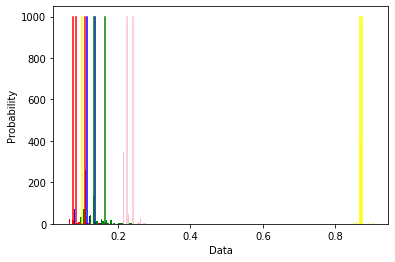

In [103]:

  # `density=False` would make counts
plt.hist(scores_f1, density=False, bins=50, color='blue')
plt.plot([np.mean(scores_f1)]*1000,np.arange(0,1000), color='blue')
plt.plot([np.mean(scores_f1)+np.std(scores_f1, ddof=1)]*1000,np.arange(0,1000), color='blue')

plt.hist(scores_f2, density=False, bins=50, color='yellow')
plt.plot([np.mean(scores_f2)]*1000,np.arange(0,1000), color='yellow')
plt.plot([np.mean(scores_f2)+np.std(scores_f2, ddof=1)]*1000,np.arange(0,1000), color='yellow')

plt.hist(scores_f3, density=False, bins=50, color='green')
plt.plot([np.mean(scores_f3)]*1000,np.arange(0,1000), color='green')
plt.plot([np.mean(scores_f3)+np.std(scores_f3, ddof=1)]*1000,np.arange(0,1000), color='green')

plt.hist(scores_f4, density=False, bins=50, color='pink')
plt.plot([np.mean(scores_f4)]*1000,np.arange(0,1000), color='pink')
plt.plot([np.mean(scores_f4)+np.std(scores_f4, ddof=1)]*1000,np.arange(0,1000), color='pink')

plt.hist(scores_original, density=False, bins=50, color='red')
plt.plot([np.mean(scores)]*1000,np.arange(0,1000), color='red')
plt.plot([np.mean(scores)+np.std(scores, ddof=1)]*1000,np.arange(0,1000), color='red')
plt.plot([np.median(scores)]*1000,np.arange(0,1000), color='red')
plt.plot([0.1]*1000,np.arange(0,1000), color='yellow')

plt.ylabel('Probability')
plt.xlabel('Data');

In [106]:
np.std(scores, ddof=1)

0.024334286807745683